Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [147]:
df.isnull().sum().sort_values()

BOROUGH                               0
BUILDING_CLASS_AT_TIME_OF_SALE        0
TAX_CLASS_AT_TIME_OF_SALE             0
SALE_PRICE                            0
ADDRESS                               0
SALE_DATE                             0
BLOCK                                 0
BUILDING_CLASS_CATEGORY               0
NEIGHBORHOOD                          0
LOT                                   0
BUILDING_CLASS_AT_PRESENT             1
TAX_CLASS_AT_PRESENT                  1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
GROSS_SQUARE_FEET                     1
ZIP_CODE                              1
YEAR_BUILT                           35
LAND_SQUARE_FEET                     53
APARTMENT_NUMBER                  17839
EASE-MENT                         23040
dtype: int64

In [0]:
df= df.drop(['EASE-MENT'], axis=1)

In [149]:
df= df.fillna('None')
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
APARTMENT_NUMBER                  0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [150]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [151]:
df['SALE_DATE'].dt.month.value_counts()

1    6464
3    6105
2    5598
4    4873
Name: SALE_DATE, dtype: int64

In [152]:
train= df[df.SALE_DATE.dt.month<4]
test = df[df.SALE_DATE.dt.month >= 4]
train.shape, test.shape

((18167, 20), (4873, 20))

In [153]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,18167.0,4.447262e+03,3.679406e+03,1.0,1343.0,3569.0,6656.0,16350.0
LOT,18167.0,3.436415e+02,6.061895e+02,1.0,21.0,49.0,286.0,9022.0
TAX_CLASS_AT_TIME_OF_SALE,18167.0,1.617053e+00,8.073494e-01,1.0,1.0,1.0,2.0,4.0
SALE_PRICE,18167.0,1.217331e+06,1.092122e+07,0.0,0.0,430000.0,840056.0,850000000.0


In [154]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BOROUGH,18167,5,4,5883,NaT,NaT
TAX_CLASS_AT_PRESENT,18167,10,1,8911,NaT,NaT
NEIGHBORHOOD,18167,11,OTHER,15034,NaT,NaT
COMMERCIAL_UNITS,18167,34,0,16448,NaT,NaT
BUILDING_CLASS_CATEGORY,18167,43,01 ONE FAMILY DWELLINGS,4094,NaT,NaT
RESIDENTIAL_UNITS,18167,75,1,7487,NaT,NaT
TOTAL_UNITS,18167,83,1,8085,NaT,NaT
SALE_DATE,18167,90,2019-01-24 00:00:00,480,2019-01-01,2019-03-31
BUILDING_CLASS_AT_PRESENT,18167,140,D4,2640,NaT,NaT
YEAR_BUILT,18167,140,1920,1420,NaT,NaT


In [155]:
df.NEIGHBORHOOD.value_counts()

OTHER                      19117
FLUSHING-NORTH               685
UPPER EAST SIDE (59-79)      465
UPPER EAST SIDE (79-96)      410
BEDFORD STUYVESANT           408
BOROUGH PARK                 376
UPPER WEST SIDE (59-79)      350
GRAMERCY                     323
ASTORIA                      312
FOREST HILLS                 298
EAST NEW YORK                296
Name: NEIGHBORHOOD, dtype: int64

In [156]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
NEIGHBORHOOD,,,,,,,,
ASTORIA,266.0,2.134987e+06,1.029145e+07,0.0,0.0,370602.5,919375.0,75000000.0
BEDFORD STUYVESANT,335.0,9.473171e+05,2.594166e+06,0.0,0.0,646589.0,1117500.0,32500000.0
BOROUGH PARK,285.0,4.562094e+05,8.552372e+05,0.0,0.0,0.0,865000.0,9650000.0
EAST NEW YORK,242.0,5.834175e+05,2.291500e+06,0.0,0.0,350000.0,643701.5,24150000.0
FLUSHING-NORTH,549.0,6.626492e+05,2.042354e+06,0.0,0.0,295469.0,836000.0,40433512.0
FOREST HILLS,237.0,5.214604e+05,6.479132e+05,0.0,190000.0,365000.0,675000.0,6205000.0
GRAMERCY,282.0,8.226612e+05,1.694401e+06,0.0,0.0,0.0,1043750.0,18000000.0
OTHER,15034.0,1.209592e+06,1.181147e+07,0.0,0.0,420000.0,810000.0,850000000.0
UPPER EAST SIDE (59-79),343.0,3.335407e+06,7.880025e+06,0.0,467500.0,950000.0,2500000.0,68000000.0


In [157]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
ASTORIA                    2.134987e+06
BEDFORD STUYVESANT         9.473171e+05
BOROUGH PARK               4.562094e+05
EAST NEW YORK              5.834175e+05
FLUSHING-NORTH             6.626492e+05
FOREST HILLS               5.214604e+05
GRAMERCY                   8.226612e+05
OTHER                      1.209592e+06
UPPER EAST SIDE (59-79)    3.335407e+06
UPPER EAST SIDE (79-96)    1.737515e+06
UPPER WEST SIDE (59-79)    1.302832e+06
Name: SALE_PRICE, dtype: float64

### One-hot encoding

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['COMMERCIAL_UNITS','BUILDING_CLASS_CATEGORY', 'SALE_DATE', 'BUILDING_CLASS_AT_PRESENT',
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'ADDRESS']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [159]:
print(X_train.shape)
X_train.head()

(18167, 11)


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
0,1,OTHER,2,716,1246,10011,1,1,1979,2007,2
1,1,OTHER,4,812,68,10018,0,6,15435,1920,4
2,1,OTHER,4,839,69,10018,0,7,11332,1930,4
3,1,OTHER,2,592,1041,10014,1,1,500,0,2
4,1,UPPER EAST SIDE (59-79),2C,1379,1402,10065,1,1,6406,0,2


In [0]:
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [161]:
print(X_train.shape)
X_train.head()

(18167, 4049)


,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_2B,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_1A,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE_10011.0,ZIP_CODE_10018.0,ZIP_CODE_10014.0,ZIP_CODE_10065.0,ZIP_CODE_10128.0,ZIP_CODE_10025.0,ZIP_CODE_10461.0,ZIP_CODE_0.0,ZIP_CODE_10466.0,ZIP_CODE_11209.0,ZIP_CODE_11219.0,ZIP_CODE_11236.0,...,YEAR_BUILT_2011.0,YEAR_BUILT_1966.0,YEAR_BUILT_1916.0,YEAR_BUILT_1937.0,YEAR_BUILT_1903.0,YEAR_BUILT_1932.0,YEAR_BUILT_1906.0,YEAR_BUILT_1982.0,YEAR_BUILT_1991.0,YEAR_BUILT_1907.0,YEAR_BUILT_1839.0,YEAR_BUILT_1911.0,YEAR_BUILT_1946.0,YEAR_BUILT_1913.0,YEAR_BUILT_1979.0,YEAR_BUILT_1895.0,YEAR_BUILT_1918.0,YEAR_BUILT_None,YEAR_BUILT_1890.0,YEAR_BUILT_1800.0,YEAR_BUILT_1944.0,YEAR_BUILT_1936.0,YEAR_BUILT_1850.0,YEAR_BUILT_1934.0,YEAR_BUILT_1942.0,YEAR_BUILT_1870.0,YEAR_BUILT_1904.0,YEAR_BUILT_1880.0,YEAR_BUILT_1883.0,YEAR_BUILT_1845.0,YEAR_BUILT_1894.0,YEAR_BUILT_1889.0,YEAR_BUILT_2019.0,YEAR_BUILT_1830.0,YEAR_BUILT_1886.0,YEAR_BUILT_1875.0,YEAR_BUILT_1898.0,YEAR_BUILT_1881.0,YEAR_BUILT_1844.0,TAX_CLASS_AT_TIME_OF_SALE
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,716,1246,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,812,68,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,839,69,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,592,1041,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1379,1402,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


### Feature Selection

In [162]:
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func = f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((18167, 15), (4873, 15))

In [163]:
all_names= X_train.columns
selected_mask = selector.get_support()
selected_names= all_names[selected_mask]
unselected_names= all_names[~selected_mask]

print('Features Seected:')
for name in selected_names:
  print(name)

Features Seected:
ZIP_CODE_10018.0
RESIDENTIAL_UNITS_283.0
RESIDENTIAL_UNITS_450.0
TOTAL_UNITS_21.0
TOTAL_UNITS_286.0
TOTAL_UNITS_451.0
TOTAL_UNITS_570.0
GROSS_SQUARE_FEET_574675.0
GROSS_SQUARE_FEET_805467.0
GROSS_SQUARE_FEET_517158.0
GROSS_SQUARE_FEET_536719.0
GROSS_SQUARE_FEET_305542.0
GROSS_SQUARE_FEET_697029.0
GROSS_SQUARE_FEET_483148.0
GROSS_SQUARE_FEET_197027.0


In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1 , len(X_train.columns)+1):
  print(f'{k}features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')


1features
Test Mean Absolute Error: $1,781,542 

2features
Test Mean Absolute Error: $1,764,488 

3features
Test Mean Absolute Error: $1,752,042 

4features
Test Mean Absolute Error: $1,740,677 

5features
Test Mean Absolute Error: $1,731,104 

6features
Test Mean Absolute Error: $1,731,135 

7features
Test Mean Absolute Error: $1,731,133 

8features
Test Mean Absolute Error: $1,743,799 

9features
Test Mean Absolute Error: $1,736,055 

10features
Test Mean Absolute Error: $1,724,637 

11features
Test Mean Absolute Error: $1,724,671 

12features
Test Mean Absolute Error: $1,717,554 

13features
Test Mean Absolute Error: $1,717,492 

14features
Test Mean Absolute Error: $1,717,501 

15features
Test Mean Absolute Error: $1,717,155 

16features
Test Mean Absolute Error: $1,711,251 

17features
Test Mean Absolute Error: $1,710,842 

18features
Test Mean Absolute Error: $1,705,199 

19features
Test Mean Absolute Error: $1,699,835 

20features
Test Mean Absolute Error: $1,691,437 

21feature

KeyboardInterrupt: ignored

### Ridge Regression

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

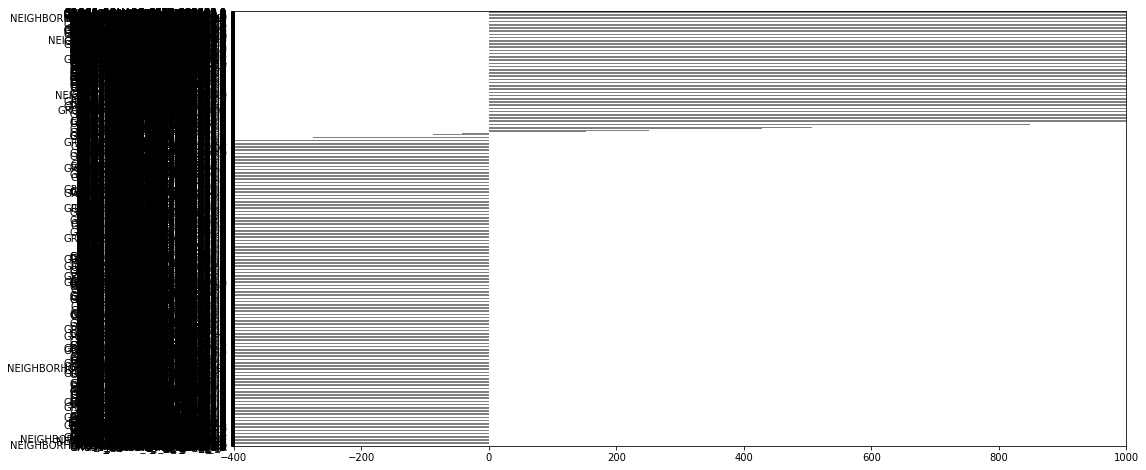

KeyboardInterrupt: ignored

In [166]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)

    # Get Train MAE
    y_pred = model.predict(X_train_scaled)
    mae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${mae:,.0f}'))

    # Get Test MAE
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,1000)
    plt.show()